#Load data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
secret_path="/content/drive/MyDrive/gold_prices.csv"

# Import libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum,lag, array, struct,expr
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType

# Data Preprocessing (debug)

In [ ]:

spark = SparkSession.builder \
    .appName("Read Gold Prices CSV") \
    .getOrCreate()

schema = StructType([
    StructField("Date", DateType(), True),
    StructField("Buy Price", DoubleType(), True),
    StructField("Sell Price", DoubleType(), True)
])

df = spark.read.option("header", True).schema(schema).csv(secret_path)



In [ ]:
df.show()


+----------+---------+----------+
|      Date|Buy Price|Sell Price|
+----------+---------+----------+
|2009-08-01|   21.130|    21.190|
|2009-08-02|   21.130|    21.190|
|2009-08-03|   21.130|    21.190|
|2009-08-04|   21.130|    21.190|
|2009-08-05|   21.130|    21.190|
|2009-08-06|   21.130|    21.190|
|2009-08-07|   21.130|    21.190|
|2009-08-08|   21.130|    21.190|
|2009-08-09|   21.130|    21.190|
|2009-08-10|   21.130|    21.190|
|2009-08-11|   21.130|    21.190|
|2009-08-12|   21.130|    21.190|
|2009-08-13|   21.130|    21.190|
|2009-08-14|   21.130|    21.190|
|2009-08-15|   21.130|    21.190|
|2009-08-16|   21.130|    21.190|
|2009-08-17|   21.130|    21.190|
|2009-08-18|   21.130|    21.190|
|2009-08-19|   21.130|    21.190|
|2009-08-20|   21.130|    21.190|
+----------+---------+----------+
only showing top 20 rows



## Check duplicate ,null value

In [ ]:
df.select([sum(col(c).isNull().cast("int")).alias(c + "_nulls") for c in df.columns]).show()


+----------+---------------+----------------+
|Date_nulls|Buy Price_nulls|Sell Price_nulls|
+----------+---------------+----------------+
|         0|              0|               0|
+----------+---------------+----------------+



In [ ]:
# Count total number of rows
total_rows = df.count()

# Count number of distinct rows
distinct_rows = df.distinct().count()

# Calculate duplicates
duplicate_count = total_rows - distinct_rows

print(f"Total Rows: {total_rows}")
print(f"Distinct Rows: {distinct_rows}")
print(f"Duplicate Rows: {duplicate_count}")


Total Rows: 5565
Distinct Rows: 5565
Duplicate Rows: 0


##Plot Open Price and Close Price

In [ ]:
pdf = df.toPandas()

In [ ]:
# In thông tin cơ bản về DataFrame
print(pdf.info())

# Kiểm tra kiểu dữ liệu từng cột
print(pdf.dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        5565 non-null   object
 1   Buy Price   5565 non-null   object
 2   Sell Price  5565 non-null   object
dtypes: object(3)
memory usage: 130.6+ KB
None
Date          object
Buy Price     object
Sell Price    object
dtype: object


In [ ]:
import pandas as pd
pdf['Buy Price'] = pd.to_numeric(pdf['Buy Price'], errors='coerce')
pdf['Sell Price'] = pd.to_numeric(pdf['Sell Price'], errors='coerce')

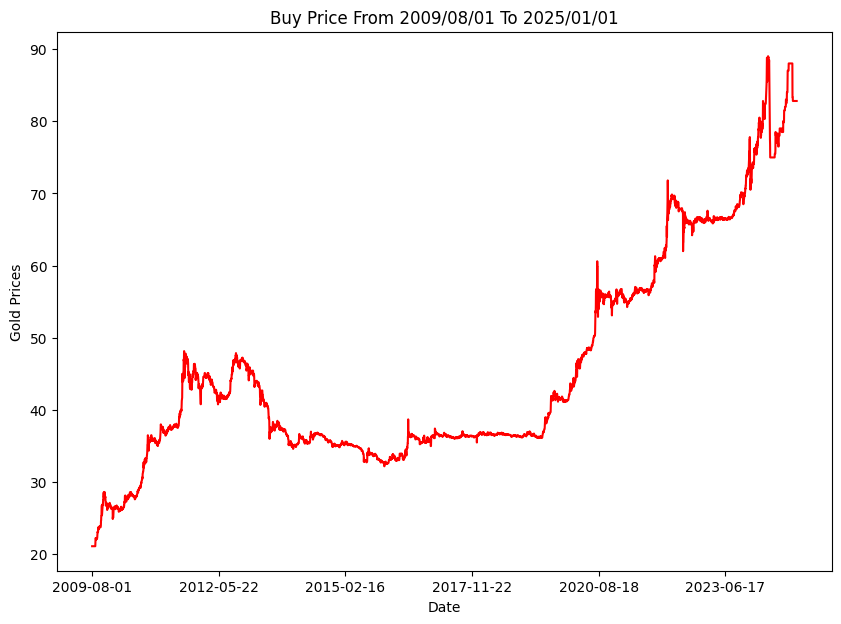

In [ ]:
pdf = pdf.set_index('Date')  # Đảm bảo 'Date' là chỉ số dòng
pdf['Buy Price'].plot(figsize=(10, 7), color='r')
plt.ylabel("Gold Prices")
plt.title("Buy Price From 2009/08/01 To 2025/01/01")
plt.show()

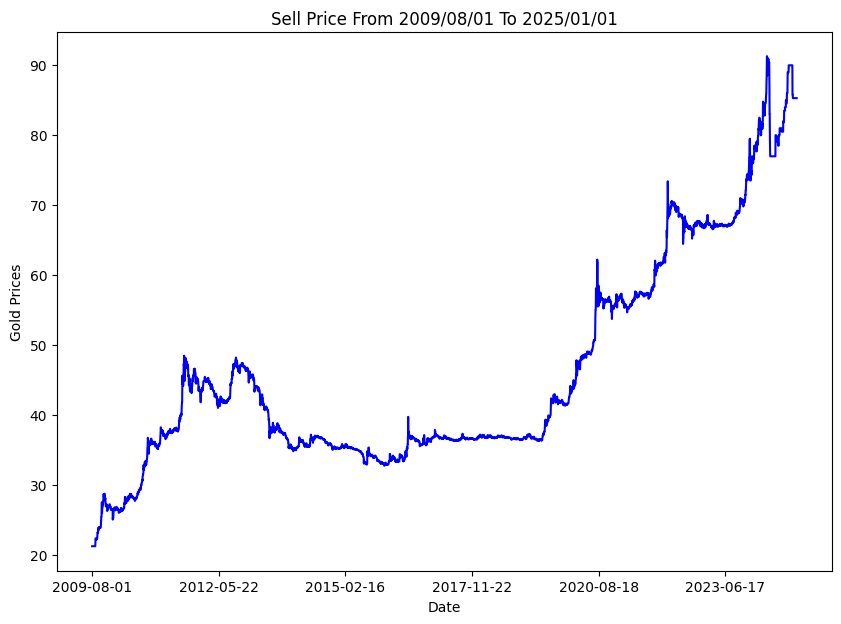

In [ ]:
pdf = pdf.set_index('Date')  # Đảm bảo 'Date' là chỉ số dòng
pdf['Sell Price'].plot(figsize=(10, 7), color='b')
plt.ylabel("Gold Prices")
plt.title("Sell Price From 2009/08/01 To 2025/01/01")
plt.show()

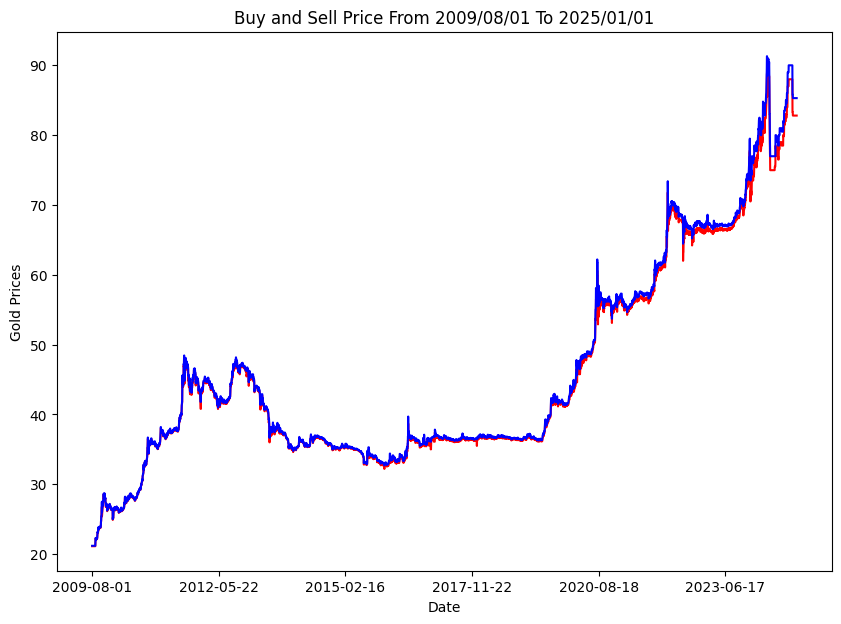

In [ ]:
pdf = pdf.set_index('Date')  # Đảm bảo 'Date' là chỉ số dòng
pdf['Buy Price'].plot(figsize=(10, 7), color='r')
pdf['Sell Price'].plot(figsize=(10, 7), color='b')
plt.ylabel("Gold Prices")
plt.title("Buy and Sell Price From 2009/08/01 To 2025/01/01")
plt.show()

# Generate samples with features and labels as below



* Features: gold prices of 10 consecutive previous dates of the date t

* Label: the gold price of the date t.


In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import lag, col, expr
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType

window = Window.orderBy("Date")

# --- Tạo df_buy ---
df_buy = df

# Tạo lag cho 10 ngày trước của Buy Price
for i in range(1, 11):
    df_buy = df_buy.withColumn(f"Buy_{i}", lag("Buy Price", i).over(window))

feature_cols_buy = [f"Buy_{i}" for i in range(10, 0, -1)]

# Cast sang DoubleType
for c in feature_cols_buy:
    df_buy = df_buy.withColumn(c, col(c).cast(DoubleType()))

# Lọc bỏ dòng có null trong các cột lag
df_buy = df_buy.where(~expr("exists(array(" + ",".join(feature_cols_buy) + "), x -> x is null)"))

# VectorAssembler cho features Buy
assembler_buy = VectorAssembler(inputCols=feature_cols_buy, outputCol="features")
df_buy = assembler_buy.transform(df_buy)

# Tạo label Buy Price
df_buy = df_buy.withColumn("label", col("Buy Price").cast(DoubleType()))

# Lấy cột cần thiết
df_buy = df_buy.select("Date", "features", "label")


# --- Tạo df_sell ---
df_sell = df

# Tạo lag cho 10 ngày trước của Sell Price
for i in range(1, 11):
    df_sell = df_sell.withColumn(f"Sell_{i}", lag("Sell Price", i).over(window))

feature_cols_sell = [f"Sell_{i}" for i in range(10, 0, -1)]

# Cast sang DoubleType
for c in feature_cols_sell:
    df_sell = df_sell.withColumn(c, col(c).cast(DoubleType()))

# Lọc bỏ dòng có null trong các cột lag
df_sell = df_sell.where(~expr("exists(array(" + ",".join(feature_cols_sell) + "), x -> x is null)"))

# VectorAssembler cho features Sell
assembler_sell = VectorAssembler(inputCols=feature_cols_sell, outputCol="features")
df_sell = assembler_sell.transform(df_sell)

# Tạo label Sell Price
df_sell = df_sell.withColumn("label", col("Sell Price").cast(DoubleType()))

# Lấy cột cần thiết
df_sell = df_sell.select("Date", "features", "label")

# Hiển thị kết quả
df_buy.show(truncate=False)
df_sell.show(truncate=False)


+----------+-------------------------------------------------------------+-----+
|Date      |features                                                     |label|
+----------+-------------------------------------------------------------+-----+
|2009-08-11|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-12|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-13|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-14|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-15|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-16|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-17|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-18|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-19|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-20|[21.13,21.13,21.

# Buy Price

## Split including training and test, with the ratio 7:3.

In [ ]:


# Split the data into training and testing datasets
train_data_buy, test_data_buy = df_buy.randomSplit([0.7, 0.3], seed=123)



In [ ]:
train_data_buy.count() , test_data_buy.count()

(3868, 1687)

##Train model

In [ ]:
# Initialize the Linear Regression model
lr = LinearRegression(
    featuresCol='features',
    labelCol='label',
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.8,
    tol=1e-6
)

# Train the model on the training data
lr_model = lr.fit(train_data_buy)



## Evaluation model by 2 sets

In [ ]:
# Đánh giá trên train
train_summary = lr_model.evaluate(train_data_buy)
train_rmse = train_summary.rootMeanSquaredError
train_r2 = train_summary.r2

# Đánh giá trên test
test_summary = lr_model.evaluate(test_data_buy)
test_rmse = test_summary.rootMeanSquaredError
test_r2 = test_summary.r2


In [ ]:
print(f"Train RMSE: {train_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")
#

Train RMSE: 0.43458662239639423
Train R2: 0.9991562578728552
Test RMSE: 0.4118046115231098
Test R2: 0.9992099986853407


##Draw a line chart to illustrate losses during the training process.

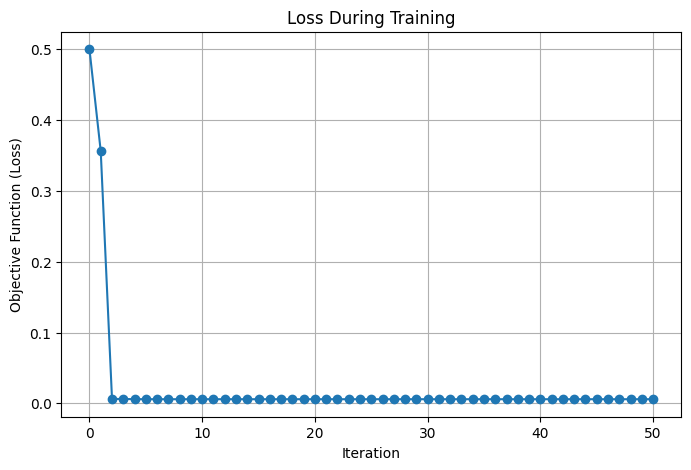

In [ ]:

# Giả sử bạn đã huấn luyện model rồi
training_summary = lr_model.summary

# Lấy lịch sử loss (objective function values)
loss_history = training_summary.objectiveHistory

# Vẽ loss qua các vòng lặp
plt.figure(figsize=(8,5))
plt.plot(range(len(loss_history)), loss_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function (Loss)')
plt.title('Loss During Training')
plt.grid(True)
plt.show()


##Draw a bar chart to contrast the results in the training and test sets.

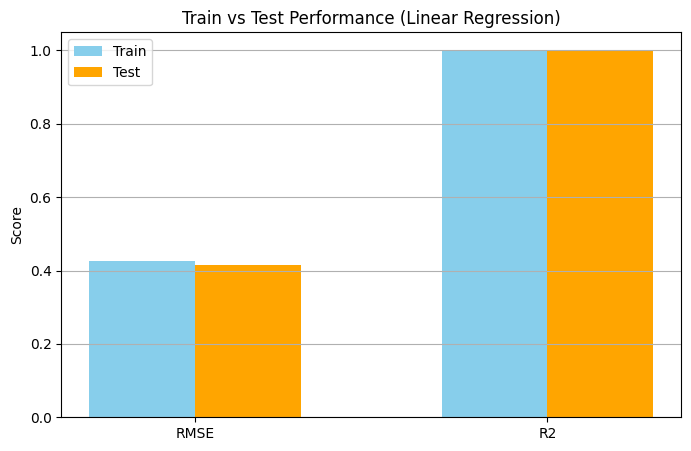

In [ ]:

# Dữ liệu để vẽ
metrics = ['RMSE', 'R2']
train_scores = [train_rmse, train_r2]
test_scores = [test_rmse, test_r2]

x = range(len(metrics))  # [0, 1]

plt.figure(figsize=(8,5))
plt.bar([i - 0.15 for i in x], train_scores, width=0.3, label='Train', color='skyblue')
plt.bar([i + 0.15 for i in x], test_scores, width=0.3, label='Test', color='orange')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Train vs Test Performance (Linear Regression)')
plt.legend()
plt.grid(axis='y')
plt.show()


## Show Predict (debug)

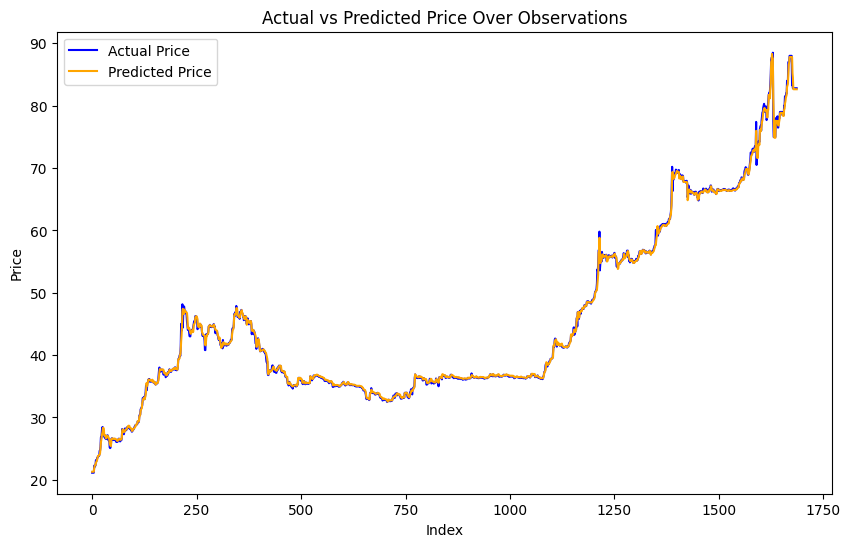

In [ ]:
import matplotlib.pyplot as plt
test_predictions=lr_model.transform(test_data_buy)
# Chuyển dữ liệu sang pandas để dễ vẽ
pandas_df = test_predictions.select("label", "prediction").toPandas()

# Nếu chưa có cột index, tạo index để làm trục x
pandas_df['index'] = pandas_df.index

plt.figure(figsize=(10,6))

# Vẽ đường giá thực
plt.plot(pandas_df['index'], pandas_df['label'], label='Actual Price', color='blue')

# Vẽ đường giá dự đoán
plt.plot(pandas_df['index'], pandas_df['prediction'], label='Predicted Price', color='orange')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs Predicted Price Over Observations')
plt.legend()
plt.show()


#Sell Price

## Split including training and test, with the ratio 7:3.

In [ ]:


# Split the data into training and testing datasets
train_data_sell, test_data_sell = df_sell.randomSplit([0.7, 0.3], seed=123)



In [ ]:
train_data_sell.count() , test_data_sell.count()

(3868, 1687)

##Train model

In [ ]:
# Initialize the Linear Regression model
lr = LinearRegression(
    featuresCol='features',
    labelCol='label',
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.8,
    tol=1e-6
)

# Train the model on the training data
lr_model = lr.fit(train_data_sell)



## Evaluation model by 2 sets

In [ ]:
# Đánh giá trên train
train_summary = lr_model.evaluate(train_data_sell)
train_rmse = train_summary.rootMeanSquaredError
train_r2 = train_summary.r2

# Đánh giá trên test
test_summary = lr_model.evaluate(test_data_sell)
test_rmse = test_summary.rootMeanSquaredError
test_r2 = test_summary.r2


In [ ]:
print(f"Train RMSE: {train_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")


Train RMSE: 0.42533719066714337
Train R2: 0.9992403673080916
Test RMSE: 0.4141489862310511
Test R2: 0.9992467530877561


##Draw a line chart to illustrate losses during the training process.

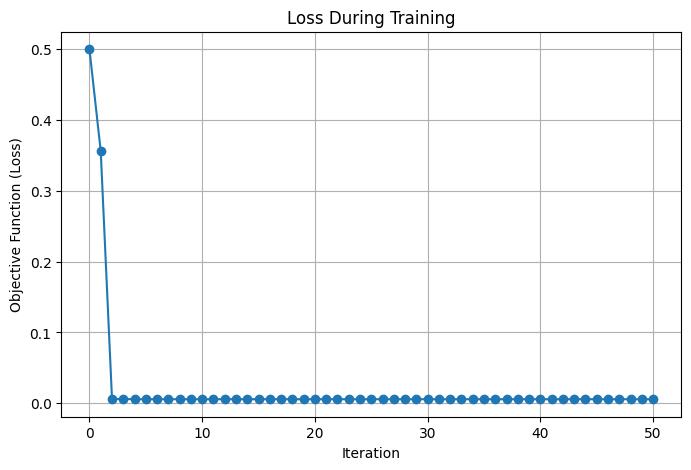

In [ ]:

# Giả sử bạn đã huấn luyện model rồi
training_summary = lr_model.summary

# Lấy lịch sử loss (objective function values)
loss_history = training_summary.objectiveHistory

# Vẽ loss qua các vòng lặp
plt.figure(figsize=(8,5))
plt.plot(range(len(loss_history)), loss_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function (Loss)')
plt.title('Loss During Training')
plt.grid(True)
plt.show()


##Draw a bar chart to contrast the results in the training and test sets.

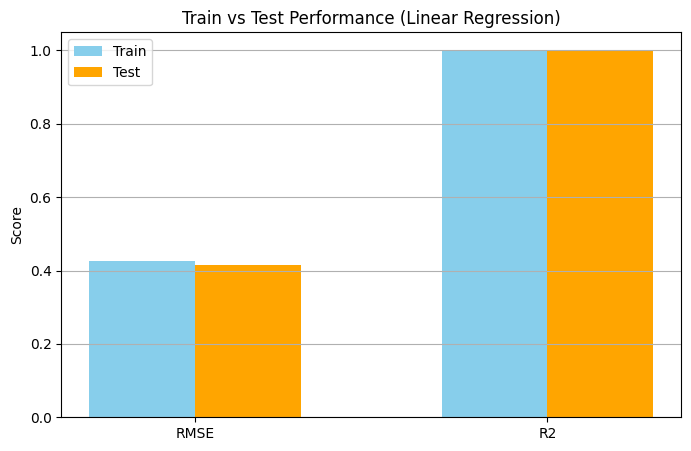

In [ ]:

# Dữ liệu để vẽ
metrics = ['RMSE', 'R2']
train_scores = [train_rmse, train_r2]
test_scores = [test_rmse, test_r2]

x = range(len(metrics))  # [0, 1]

plt.figure(figsize=(8,5))
plt.bar([i - 0.15 for i in x], train_scores, width=0.3, label='Train', color='skyblue')
plt.bar([i + 0.15 for i in x], test_scores, width=0.3, label='Test', color='orange')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Train vs Test Performance (Linear Regression)')
plt.legend()
plt.grid(axis='y')
plt.show()


## Show Predict (debug)

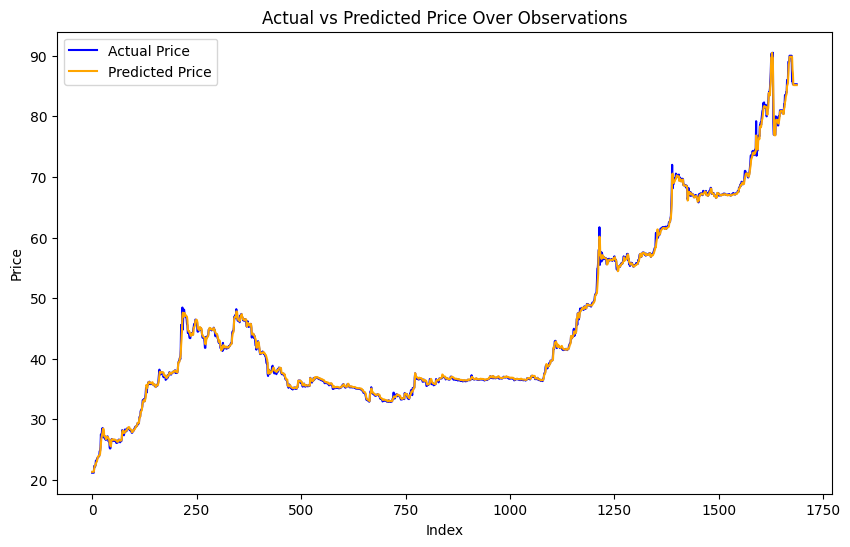

In [ ]:
import matplotlib.pyplot as plt
test_predictions=lr_model.transform(test_data_sell)
# Chuyển dữ liệu sang pandas để dễ vẽ
pandas_df = test_predictions.select("label", "prediction").toPandas()

# Nếu chưa có cột index, tạo index để làm trục x
pandas_df['index'] = pandas_df.index

plt.figure(figsize=(10,6))

# Vẽ đường giá thực
plt.plot(pandas_df['index'], pandas_df['label'], label='Actual Price', color='blue')

# Vẽ đường giá dự đoán
plt.plot(pandas_df['index'], pandas_df['prediction'], label='Predicted Price', color='orange')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs Predicted Price Over Observations')
plt.legend()
plt.show()
